[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 50)            8400      
                                                                 
 gru_1 (GRU)                 (None, 60, 50)            15300     
                                                                 
 gru_2 (GRU)                 (None, 50)                15300     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 39051 (152.54 KB)
Trainable params: 39051 (152.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________

Epoch 67/100
10/10 [==============================] - 1s 82ms/step - loss: 6.6517e-04 - val_loss: 4.6698e-04
Epoch 68/100
10/10 [==============================] - 1s 89ms/step - loss: 6.8811e-04 - val_loss: 8.0255e-04
Epoch 69/100
10/10 [==============================] - 1s 87ms/step - loss: 6.7908e-04 - val_loss: 4.8159e-04
Epoch 70/100
10/10 [==============================] - 1s 87ms/step - loss: 6.5984e-04 - val_loss: 4.4657e-04
Epoch 71/100
10/10 [==============================] - 1s 77ms/step - loss: 6.6918e-04 - val_loss: 4.4575e-04
Epoch 72/100
10/10 [==============================] - 1s 82ms/step - loss: 6.7836e-04 - val_loss: 4.5950e-04
Epoch 73/100
10/10 [==============================] - 1s 82ms/step - loss: 7.6313e-04 - val_loss: 7.6892e-04
Epoch 74/100
10/10 [==============================] - 1s 79ms/step - loss: 7.1640e-04 - val_loss: 4.3509e-04
Epoch 75/100
10/10 [==============================] - 1s 80ms/step - loss: 6.6910e-04 - val_loss: 4.7550e-04
Epoch 76/100
10/10 

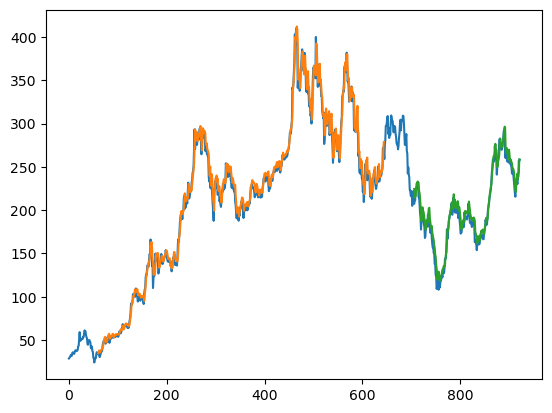

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import GRU
import matplotlib.pyplot as plt
import time

# get stock data
symbol = "TSLA"
start_date = "2020-01-01"
end_date = "2023-09-01"
data = yf.download(symbol, start=start_date, end=end_date)

# get VIX data
vix_data = yf.download("^VIX", start=start_date, end=end_date)
vix_data = vix_data[['Close']]

# get risk-free interest rate
tnx_data = yf.download("^TNX", start=start_date, end=end_date)
tnx_data = tnx_data[['Close']]

# make data set
data = data.join(vix_data, rsuffix='_VIX')
data = data.join(tnx_data, rsuffix='_TNX')
data = data.fillna(method='ffill')
price_volume_vix_tnx_data = data[['Close', 'Volume', 'Close_VIX', 'Close_TNX']].values

# Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(price_volume_vix_tnx_data)

# split train and test set
train_size = int(len(scaled_data) * 0.7)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

# create input dataset function
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 60
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# build GRU model
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))  # input layer
model.add(GRU(50, return_sequences=True))  # hidden layer
model.add(GRU(50))  # hidden layer
model.add(Dense(1))  # output layer
model.compile(loss='mean_squared_error', optimizer='adam')

# summarize model
model.summary()

# check the running time
start_time = time.time()

# training
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=32, verbose=1)

# end to check the time
end_time = time.time()

# print the running time
print("Learning time: ", end_time - start_time, "seconds")


# prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# inverse_scaling
train_predict = scaler.inverse_transform(np.column_stack((train_predict, np.zeros_like(train_predict), np.zeros_like(train_predict), np.zeros_like(train_predict))))
test_predict = scaler.inverse_transform(np.column_stack((test_predict, np.zeros_like(test_predict), np.zeros_like(test_predict), np.zeros_like(test_predict))))
train_predict = train_predict[:, 0]
test_predict = test_predict[:, 0]

trainY_original = scaler.inverse_transform(np.column_stack((Y_train, np.zeros_like(Y_train), np.zeros_like(Y_train), np.zeros_like(Y_train))))[:, 0]
testY_original = scaler.inverse_transform(np.column_stack((Y_test, np.zeros_like(Y_test), np.zeros_like(Y_test), np.zeros_like(Y_test))))[:, 0]

# get RMSE
print("Train RMSE: ", np.sqrt(mean_squared_error(trainY_original, train_predict)))
print("Test RMSE: ", np.sqrt(mean_squared_error(testY_original, test_predict)))

# plotting
look_back = 60
trainPredictPlot = np.empty_like(price_volume_vix_tnx_data[:, 0])
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back] = train_predict

testPredictPlot = np.empty_like(price_volume_vix_tnx_data[:, 0])
testPredictPlot[:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(scaled_data) - 1] = test_predict

plt.plot(scaler.inverse_transform(scaled_data)[:, 0])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [4]:
# Define a range of batch sizes to experiment with
batch_sizes = [16, 32, 64, 128, 256]

# Store results for comparison
results = []

for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size}")
    
    # Train the model
    model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=batch_size, verbose=1)

    # prediction
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # inverse_scaling
    train_predict = scaler.inverse_transform(np.column_stack((train_predict, np.zeros_like(train_predict), np.zeros_like(train_predict), np.zeros_like(train_predict))))
    test_predict = scaler.inverse_transform(np.column_stack((test_predict, np.zeros_like(test_predict), np.zeros_like(test_predict), np.zeros_like(test_predict))))
    train_predict = train_predict[:, 0]
    test_predict = test_predict[:, 0]

    trainY_original = scaler.inverse_transform(np.column_stack((Y_train, np.zeros_like(Y_train), np.zeros_like(Y_train), np.zeros_like(Y_train))))[:, 0]
    testY_original = scaler.inverse_transform(np.column_stack((Y_test, np.zeros_like(Y_test), np.zeros_like(Y_test), np.zeros_like(Y_test))))[:, 0]
    
    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(trainY_original, train_predict))
    test_rmse = np.sqrt(mean_squared_error(testY_original, test_predict))
    
    print(f"Batch Size: {batch_size}, Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

    # Save results
    results.append((batch_size, train_rmse, test_rmse))

# Displaying results
for result in results:
    print(f"Batch Size: {result[0]}, Train RMSE: {result[1]}, Test RMSE: {result[2]}")



Training with batch size: 16
Epoch 1/100
37/37 [==============================] - 2s 61ms/step - loss: 7.3609e-04 - val_loss: 7.0217e-04
Epoch 2/100
37/37 [==============================] - 2s 59ms/step - loss: 7.1209e-04 - val_loss: 6.3233e-04
Epoch 3/100
37/37 [==============================] - 2s 59ms/step - loss: 6.2015e-04 - val_loss: 4.4016e-04
Epoch 4/100
37/37 [==============================] - 2s 58ms/step - loss: 6.3976e-04 - val_loss: 4.3115e-04
Epoch 5/100
37/37 [==============================] - 2s 58ms/step - loss: 6.9743e-04 - val_loss: 4.8966e-04
Epoch 6/100
37/37 [==============================] - 2s 60ms/step - loss: 5.9034e-04 - val_loss: 6.3546e-04
Epoch 7/100
37/37 [==============================] - 2s 60ms/step - loss: 7.0089e-04 - val_loss: 6.5037e-04
Epoch 8/100
37/37 [==============================] - 2s 60ms/step - loss: 6.2260e-04 - val_loss: 4.7340e-04
Epoch 9/100
37/37 [==============================] - 2s 60ms/step - loss: 7.0346e-04 - val_loss: 6.2810e-0

37/37 [==============================] - 2s 60ms/step - loss: 4.8591e-04 - val_loss: 5.2112e-04
Epoch 77/100
37/37 [==============================] - 2s 59ms/step - loss: 5.0938e-04 - val_loss: 5.3779e-04
Epoch 78/100
37/37 [==============================] - 2s 60ms/step - loss: 5.0761e-04 - val_loss: 5.4183e-04
Epoch 79/100
37/37 [==============================] - 2s 61ms/step - loss: 5.4401e-04 - val_loss: 5.2938e-04
Epoch 80/100
37/37 [==============================] - 2s 60ms/step - loss: 5.1062e-04 - val_loss: 6.5447e-04
Epoch 81/100
37/37 [==============================] - 2s 60ms/step - loss: 5.0693e-04 - val_loss: 5.7665e-04
Epoch 82/100
37/37 [==============================] - 2s 60ms/step - loss: 5.1194e-04 - val_loss: 6.9120e-04
Epoch 83/100
37/37 [==============================] - 2s 60ms/step - loss: 5.0767e-04 - val_loss: 7.9166e-04
Epoch 84/100
37/37 [==============================] - 2s 60ms/step - loss: 4.7486e-04 - val_loss: 7.6329e-04
Epoch 85/100
37/37 [============

19/19 [==============================] - 1s 66ms/step - loss: 3.8571e-04 - val_loss: 8.9970e-04
Epoch 50/100
19/19 [==============================] - 1s 67ms/step - loss: 3.6095e-04 - val_loss: 0.0011
Epoch 51/100
19/19 [==============================] - 1s 68ms/step - loss: 3.7450e-04 - val_loss: 0.0011
Epoch 52/100
19/19 [==============================] - 1s 71ms/step - loss: 3.7688e-04 - val_loss: 7.7004e-04
Epoch 53/100
19/19 [==============================] - 1s 66ms/step - loss: 3.6655e-04 - val_loss: 0.0011
Epoch 54/100
19/19 [==============================] - 1s 66ms/step - loss: 4.3205e-04 - val_loss: 0.0010
Epoch 55/100
19/19 [==============================] - 1s 67ms/step - loss: 3.8320e-04 - val_loss: 8.3470e-04
Epoch 56/100
19/19 [==============================] - 1s 66ms/step - loss: 3.4984e-04 - val_loss: 9.0614e-04
Epoch 57/100
19/19 [==============================] - 1s 67ms/step - loss: 3.5325e-04 - val_loss: 9.1105e-04
Epoch 58/100
19/19 [============================

10/10 [==============================] - 1s 77ms/step - loss: 2.1135e-04 - val_loss: 0.0015
Epoch 25/100
10/10 [==============================] - 1s 77ms/step - loss: 2.1598e-04 - val_loss: 0.0014
Epoch 26/100
10/10 [==============================] - 1s 78ms/step - loss: 2.3765e-04 - val_loss: 0.0022
Epoch 27/100
10/10 [==============================] - 1s 77ms/step - loss: 2.3949e-04 - val_loss: 0.0014
Epoch 28/100
10/10 [==============================] - 1s 76ms/step - loss: 2.3115e-04 - val_loss: 0.0014
Epoch 29/100
10/10 [==============================] - 1s 77ms/step - loss: 2.3109e-04 - val_loss: 0.0020
Epoch 30/100
10/10 [==============================] - 1s 77ms/step - loss: 2.3400e-04 - val_loss: 0.0014
Epoch 31/100
10/10 [==============================] - 1s 78ms/step - loss: 2.2030e-04 - val_loss: 0.0015
Epoch 32/100
10/10 [==============================] - 1s 77ms/step - loss: 2.3993e-04 - val_loss: 0.0015
Epoch 33/100
10/10 [==============================] - 1s 77ms/step -

5/5 [==============================] - 1s 155ms/step - loss: 1.4672e-04 - val_loss: 0.0070
Epoch 2/100
5/5 [==============================] - 1s 138ms/step - loss: 1.4184e-04 - val_loss: 0.0067
Epoch 3/100
5/5 [==============================] - 1s 135ms/step - loss: 1.3773e-04 - val_loss: 0.0064
Epoch 4/100
5/5 [==============================] - 1s 133ms/step - loss: 1.3782e-04 - val_loss: 0.0065
Epoch 5/100
5/5 [==============================] - 1s 135ms/step - loss: 1.3438e-04 - val_loss: 0.0074
Epoch 6/100
5/5 [==============================] - 1s 133ms/step - loss: 1.3068e-04 - val_loss: 0.0078
Epoch 7/100
5/5 [==============================] - 1s 137ms/step - loss: 1.3081e-04 - val_loss: 0.0086
Epoch 8/100
5/5 [==============================] - 1s 134ms/step - loss: 1.3104e-04 - val_loss: 0.0088
Epoch 9/100
5/5 [==============================] - 1s 137ms/step - loss: 1.2878e-04 - val_loss: 0.0083
Epoch 10/100
5/5 [==============================] - 1s 136ms/step - loss: 1.3123e-04 

Epoch 80/100
5/5 [==============================] - 1s 136ms/step - loss: 1.0312e-04 - val_loss: 0.0142
Epoch 81/100
5/5 [==============================] - 1s 130ms/step - loss: 1.0092e-04 - val_loss: 0.0096
Epoch 82/100
5/5 [==============================] - 1s 137ms/step - loss: 1.0142e-04 - val_loss: 0.0110
Epoch 83/100
5/5 [==============================] - 1s 135ms/step - loss: 9.6214e-05 - val_loss: 0.0121
Epoch 84/100
5/5 [==============================] - 1s 132ms/step - loss: 1.0328e-04 - val_loss: 0.0129
Epoch 85/100
5/5 [==============================] - 1s 133ms/step - loss: 9.7447e-05 - val_loss: 0.0119
Epoch 86/100
5/5 [==============================] - 1s 134ms/step - loss: 1.0206e-04 - val_loss: 0.0095
Epoch 87/100
5/5 [==============================] - 1s 133ms/step - loss: 9.5534e-05 - val_loss: 0.0122
Epoch 88/100
5/5 [==============================] - 1s 132ms/step - loss: 9.9557e-05 - val_loss: 0.0139
Epoch 89/100
5/5 [==============================] - 1s 133ms/ste

Epoch 57/100
3/3 [==============================] - 1s 186ms/step - loss: 7.6535e-05 - val_loss: 0.0144
Epoch 58/100
3/3 [==============================] - 1s 174ms/step - loss: 8.8295e-05 - val_loss: 0.0115
Epoch 59/100
3/3 [==============================] - 1s 183ms/step - loss: 7.7974e-05 - val_loss: 0.0132
Epoch 60/100
3/3 [==============================] - 1s 189ms/step - loss: 8.3247e-05 - val_loss: 0.0118
Epoch 61/100
3/3 [==============================] - 1s 182ms/step - loss: 8.0044e-05 - val_loss: 0.0111
Epoch 62/100
3/3 [==============================] - 1s 186ms/step - loss: 7.2817e-05 - val_loss: 0.0127
Epoch 63/100
3/3 [==============================] - 1s 178ms/step - loss: 7.3511e-05 - val_loss: 0.0112
Epoch 64/100
3/3 [==============================] - 1s 185ms/step - loss: 7.5842e-05 - val_loss: 0.0111
Epoch 65/100
3/3 [==============================] - 1s 176ms/step - loss: 7.0588e-05 - val_loss: 0.0118
Epoch 66/100
3/3 [==============================] - 1s 173ms/ste